In [1]:
import json
import os
import pandas as pd
from datetime import datetime
import pickle 
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
import torch
import logging
from tqdm import tqdm
from datetime import datetime
import ast
from operator import itemgetter
from collections import OrderedDict
import random


from utils.tree_utils import *
from utils.utils import *
from dataset import *
from model import *
import torch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import math
from matplotlib import pyplot as plt

In [2]:
## People
## Time
## Topic
## Media Contents


In [116]:
out_dir = '../data'
data_dir = '../data'
journalist = 'aliceysu'
batch_size = 4

In [117]:
### Data (normalize input inter-event times, then padding to create dataloaders)
num_classes, num_sequences = 0, 0
seq_dataset = []
arr = []
dp = []
rel = []

split = [100, 150]
# meifongwriter: 100, 150
# JiayangFan: 80: 84
# muyixiao: 12: 16
# lingling: 98, 99
# alice: 100, 150
val = 0
journal_sort = pd.read_csv((os.path.join(data_dir, f'{journalist}/{journalist}_conv_labels.csv')))
ids = []
for item in list(journal_sort['conversation_id']):
    if item not in ids:
        ids.append(item)
id_pair = {}
id_conv = {}
for idx in ids:
    id_pair[idx], id_conv[idx] = create_conversation_list(journal_sort[journal_sort['conversation_id']==idx], idx)
id_data, uid, data, label = create_data(journal_sort, ids)
prob = pkl.load(open(os.path.join(data_dir, f'{journalist}/{journalist}_edgeprob.pkl'), 'rb'))

with open(os.path.join(data_dir, f'{journalist}/{journalist}_global_path.txt'), "r") as f:
    for line in tqdm(f, total=get_number_of_lines(f)):
        dp.append(json.loads(line.strip()))

with open(os.path.join(data_dir, f'{journalist}/{journalist}_local_path.txt'), "r") as f:
    for line in tqdm(f, total=get_number_of_lines(f)):
        rel.append(json.loads(line.strip()))

global_input = convert_global(dp, id_data)
local_data = convert_local(rel)
local_mat = generate_local_mat(local_data, id_data)
local_input = create_mat(local_mat, mat_type='concat')
logging.info(f'loaded split {journalist}...')
num_classes = 3
#num_sequences += len(data[split]['arrival_times'])
num_sequences = len(set(journal_sort['conversation_id']))

id_train, id_dev, id_test = id_data[:split[0]], id_data[split[0]:split[1]], id_data[split[1]:]
uid_train, uid_dev, uid_test = uid[:split[0]], uid[split[0]:split[1]], uid[split[1]:]
X_train, X_dev, X_test = data[:split[0]], data[split[0]:split[1]], data[split[1]:]
prob_train, prob_dev, prob_test = prob[:split[0]], prob[split[0]:split[1]], prob[split[1]:]
global_train, global_dev, global_test = global_input[:split[0]], global_input[split[0]:split[1]], global_input[split[1]:]
local_train, local_dev, local_test = local_input[:split[0]], local_input[split[0]:split[1]], local_input[split[1]:]
label_train, label_dev, label_test = label[:split[0]], label[split[0]:split[1]], label[split[1]:]

d_train = TreeDataset(id_train, uid_train, X_train, prob_train, global_train, local_train, label_train)
d_val = TreeDataset(id_dev, uid_dev, X_dev, prob_dev, global_dev, local_dev, label_dev)  
d_test  = TreeDataset(id_test, uid_test, X_test, prob_test, global_test, local_test, label_test)   

# for padding input sequences to maxlen of batch for running on gpu, and arranging them by length efficient
collate = collate  
train = torch.utils.data.DataLoader(d_train, batch_size=batch_size, shuffle=False, collate_fn=collate)
val = torch.utils.data.DataLoader(d_val, batch_size=batch_size, shuffle=False, collate_fn=collate)
test = torch.utils.data.DataLoader(d_test, batch_size=batch_size, shuffle=False, collate_fn=collate)


100%|██████████| 419/419 [00:00<00:00, 16379.27it/s]


In [118]:
# val
with open(os.path.join(out_dir, f'{journalist}/strat_val.pkl'), 'rb') as file:
    strat_val = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/true_labels.pkl'), 'rb') as file:
    true_labels = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/pred_val.pkl'), 'rb') as file:
    pred_val = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/output_val.pkl'), 'rb') as file:
    output_val = pickle.load(file)

# with open(os.path.join(out_dir, f'{journalist}/predicted.pkl'), 'rb') as file:
#     predicted = pickle.load(file)
# train
with open(os.path.join(out_dir, f'{journalist}/strat_tr.pkl'), 'rb') as file:
    strat_train = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/pred_tr.pkl'), 'rb') as file:
    pred_train = pickle.load(file)
    
with open(os.path.join(out_dir, f'{journalist}/output.pkl'), 'rb') as file:
    output_train = pickle.load(file)
# test
with open(os.path.join(out_dir, f'{journalist}/strat_te.pkl'), 'rb') as file:
    strat_test = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/pred_te.pkl'), 'rb') as file:
    pred_test = pickle.load(file)

In [119]:
pred_te = []
for item in pred_test:
    for x in item:
        pred_te.append(x)

label_id = {}
for i in range(len(id_test)):
    for j in range(len(id_test[i])):
        if j >= len(pred_te[i]):
            continue
        label_id[id_test[i][j]] = pred_te[i][j]
for index, row in journal_sort.iterrows():
    tid = row['tweet_id']
    l = row['labels']
    if l ==0 or l == 1 or l == 2:
        continue
    else:
        if tid not in label_id.keys():
            journal_sort.loc[index, 'labels'] = random.choice([0,1,2])
        else: 
            journal_sort.loc[index, 'labels'] = label_id[tid]


In [120]:
strat_all = []
for item in (strat_train + strat_val + strat_test):
    for x in item:
        strat_all.append(x)

strat_id = {}
for i in range(len(id_data)):
    for j in range(len(id_data[i])):
        if j >= len(strat_all[i]):
            continue
        strat_id[id_data[i][j]] = strat_all[i][j]

journal_sort['strategy'] = journal_sort['tweet_id'].map(strat_id)

In [121]:
date_format = '%Y-%m-%d %H:%M:%S'
collect_time = datetime.strptime('2023-01-01 00:00:00', date_format)
conv = journal_sort.dropna(subset=['strategy']).reset_index(drop=True)

In [122]:
conv_attack = conv[conv['labels']==0] 
conv_by = conv[conv['labels']==1] 
conv_support = conv[conv['labels']==2] 

In [123]:
journal = conv_attack['author_id'].iloc[0]
conv_attack['utility_a'] = None
conv_attack['utility_b'] = None
conv_attack['utility_c'] = None
strat_id = {}
reply_utility_a = []
reply_utility_b = []
reply_utility_c = []

for index, row in conv_attack.iterrows():
    tweet_id = row['tweet_id']
    time = datetime.strptime(row['created_at'][:19], date_format)
    refer = conv[conv['reference_id']==tweet_id]
    count_a = row['like_count'] + row['quote_count'] + np.log(row['impression_count']+1) \
                    + row['reply_count'] + row['retweet_count']
    if len(refer)==0:
        attacked = 0
        by_journal = 0
    else:
        attacked = len(refer[refer['labels']==2]) + len(refer[refer['labels']==1])
        by_journal = len(refer[refer['user_id']==journal])
        # count_all = attacked + by_journal + row['like_count'] + row['quote_count'] + \
        #             (np.log(row['impression_count']+1)) + row['reply_count'] + row['retweet_count']
    delta_time_dirty = (collect_time - time).total_seconds() 
    delta_time = float(divmod(delta_time_dirty, 3600)[0]) / 480
    utility_a = count_a / delta_time
    utility_b = attacked / delta_time
    utility_c = by_journal / delta_time
    conv_attack.loc[index, 'utility_a'] = utility_a
    conv_attack.loc[index, 'utility_b'] = utility_b
    conv_attack.loc[index, 'utility_c'] = utility_c

    reply_utility_a.append([np.argmax(row['strategy']), utility_a])
    reply_utility_b.append([np.argmax(row['strategy']), utility_b])
    reply_utility_c.append([np.argmax(row['strategy']), utility_c])
    if row['user_id'] not in strat_id.keys():
        strat_id[row['user_id']] = {'strategy':[row['strategy']], 
                                    'utility_a':[utility_a],
                                    'utility_b':[utility_b],
                                    'utility_c':[utility_c]
                                    }
    else:
        strat_id[row['user_id']]['strategy'].append(row['strategy'])
        strat_id[row['user_id']]['utility_a'].append(utility_a)
        strat_id[row['user_id']]['utility_b'].append(utility_b)
        strat_id[row['user_id']]['utility_c'].append(utility_c)

user_utility = []
for k, v in strat_id.items():
    strat = np.argmax(np.mean(strat_id[k]['strategy'], axis=0))
    u_a = np.mean(strat_id[k]['utility_a'])
    u_b = np.mean(strat_id[k]['utility_b'])
    u_c = np.mean(strat_id[k]['utility_c'])
    user_utility.append([strat, u_a, u_b, u_c])

strategy = {'a':{}, 'b':{}, 'c':{}}
for item in user_utility:
    if item[0] not in strategy['a'].keys():
        strategy['a'][item[0]] = [item[1]]
        strategy['b'][item[0]] = [item[2]]
        strategy['c'][item[0]] = [item[3]]
    else:
        strategy['a'][item[0]].append(item[1])
        strategy['b'][item[0]].append(item[2])
        strategy['c'][item[0]].append(item[3])

alice_attack = {'a': OrderedDict(sorted(strategy['a'].items())),
                       'b': OrderedDict(sorted(strategy['b'].items())),
                       'c': OrderedDict(sorted(strategy['c'].items())),
                       }

/tmp/ipykernel_3662180/2670526621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conv_attack['utility_a'] = None
/tmp/ipykernel_3662180/2670526621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conv_attack['utility_b'] = None
/tmp/ipykernel_3662180/2670526621.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [55]:
# muyixiao_attack, meifong_attack, jiayangfan_attack, lingling_attack, alice_attack


In [56]:
strategy = {'a':{}, 'b':{}, 'c':{}}
for item in user_utility:
    if item[0] not in strategy['a'].keys():
        strategy['a'][item[0]] = [item[1]]
        strategy['b'][item[0]] = [item[2]]
        strategy['c'][item[0]] = [item[3]]
    else:
        strategy['a'][item[0]].append(item[1])
        strategy['b'][item[0]].append(item[2])
        strategy['c'][item[0]].append(item[3])

alice_attack = {'a': OrderedDict(sorted(strategy['a'].items())),
                       'b': OrderedDict(sorted(strategy['b'].items())),
                       'c': OrderedDict(sorted(strategy['c'].items())),
                       }

In [662]:
#sorted_dict_muyixiao = sorted_dict
#sorted_dict_jiayangfan = sorted_dict
#sorted_dict_lingling
# with open('../result/payoff_muyixiao.pkl', 'wb') as pickle_file:
#     pickle.dump(sorted_dict_muyixiao, pickle_file)
# with open('../result/payoff_jiayangfan.pkl', 'wb') as pickle_file:
#     pickle.dump(sorted_dict_jiayangfan, pickle_file)
# with open('../result/payoff_lingling.pkl', 'wb') as pickle_file:
#     pickle.dump(sorted_dict_lingling, pickle_file)
# with open('../result/payoff_meifong.pkl', 'wb') as pickle_file:
#     pickle.dump(sorted_dict_meifong, pickle_file)
with open('../result/payoff_alice.pkl', 'wb') as pickle_file:
    pickle.dump(sorted_dict_alice, pickle_file)
    
    

In [665]:
sorted_all = {}
for ind, item in sorted_dict_meifong.items():
    sorted_all[ind] = {}
    for k, v in item.items():
        sorted_all[ind][k] = v + sorted_dict_jiayangfan[ind][k] + sorted_dict_muyixiao[ind][k] + sorted_dict_lingling[ind][k] 
    # if k in sorted_dict_meifong.keys():
    #     sorted_all[k] = sorted_all[k] + sorted_dict_meifong[k]
    if k in sorted_dict_alice.keys():
        sorted_all[k] = sorted_all[k] + sorted_dict_alice[k]

In [58]:
count = {}
for ind, item in sorted_all.items():
    count[ind] = 0
    for k, v in item.items():
        for x in v:
            if x > 0.1:
                count[ind] += 1
        print(len(v), max(v))
    print("======")

7 0.4928131416837782
7 29.9229073626389
11 44.08163265306122
2 28.742514970059883
4 1.1446781369205068
7 0.0
7 2.0253164556962022
11 1.1403899225496306
2 0.5748502994011976
4 0.9974778332593098
7 0.0
7 0.0
11 0.0
2 0.0
4 0.0


In [59]:
mean = {}
for ind, item in sorted_all.items():
    mean[ind] = []
    for k, v in item.items():
        mean[ind].append(np.mean(v))
mean

{'a': [0.07040187738339689,
  5.606314266135766,
  4.660683138189717,
  15.080267824764062,
  0.7880626208978434],
 'b': [0.0,
  0.2893309222423146,
  0.16718907989831894,
  0.2874251497005988,
  0.5066233505018432],
 'c': [0.0, 0.0, 0.0, 0.0, 0.0]}

In [63]:
scale = {'a': 1, 'b': 1, 'c': 100}
sorted_scale = {'a': {}, 'b': {}, 'c': {}}
for ind, item in sorted_all.items():
    for k, v in item.items():
        sorted_scale[ind][k] = [scale[ind] * x for x in v]

mean = {'a': {}, 'b': {}, 'c': {}}
for ind, item in sorted_scale.items():
    for k, v in item.items():
        if ind == 'a':
            mean[ind][k] = np.mean(v)
        else:
            mean[ind][k] = np.mean(v)
print(mean)

c = 0
total_len = 0
for k, v in sorted_scale['b'].items():
    total_len += len(v)
    for item in v:
        if item >= 0.5066:
            c += 1
print(c / total_len)
# a: 12.0% 0.7135
# b: 10.5% 0.111
# c: 2.1% 0.0052

{'a': {1: 0.07040187738339689, 2: 5.606314266135766, 3: 4.660683138189717, 5: 15.080267824764062, 7: 0.7880626208978434}, 'b': {1: 0.0, 2: 0.2893309222423146, 3: 0.16718907989831894, 5: 0.2874251497005988, 7: 0.5066233505018432}, 'c': {1: 0.0, 2: 0.0, 3: 0.0, 5: 0.0, 7: 0.0}}
0.1935483870967742


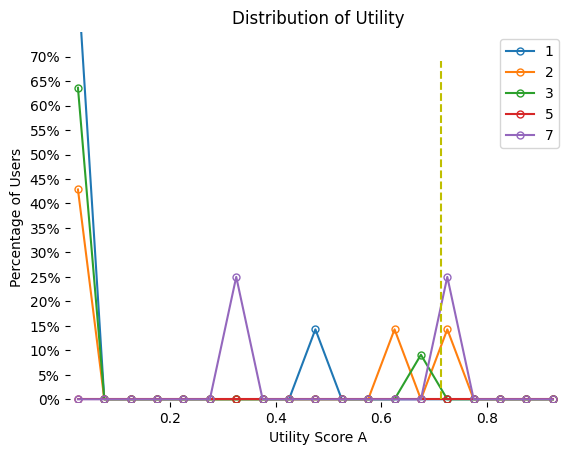

In [64]:
# Define bins with a width of 0.2 and range up to 4
bins = np.arange(0., 1, 0.05)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Calculate histogram for each dataset within the range and convert counts to percentages
total_points = {}
hist_per = {}
for k, v in sorted_all['a'].items():
    total_points[k] = len(v)
    hist, _ = np.histogram(v, bins=bins)
    hist_per[k] = (hist / total_points[k]) * 100



# Plotting the histograms as lines on the same figure
for k in hist_per.keys():
    plt.plot(bin_centers, hist_per[k], linestyle='-', marker='o', mfc='none', label=k, markersize=5)
y = range(70)
x = [0.7135] * len(y)
# Plotting the data
#plt.plot(x, y, label='Data Line')
plt.plot(x, y, 'y--') 
plt.xlim([0.01, bins[-1]])  # Adjust x-axis to include the last bin

# Remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Remove grids
plt.grid(False)

# Customize the y-axis to show percentages
max_percentage = 70 #max(max(hist_per[i]) for i in range(len(hist_per)))
plt.ylim([-0.5, max_percentage + (5 - max_percentage % 5)])  # Adjust ylim for visibility
plt.gca().set_yticks(np.arange(0, max_percentage + 1, step=5))
plt.gca().set_yticklabels([f'{x:.0f}%' for x in np.arange(0, max_percentage + 1, step=5)])

plt.xlabel('Utility Score A')
plt.ylabel('Percentage of Users')
plt.title('Distribution of Utility')
plt.legend()
plt.savefig('../result/payoff_a.png')
plt.show()


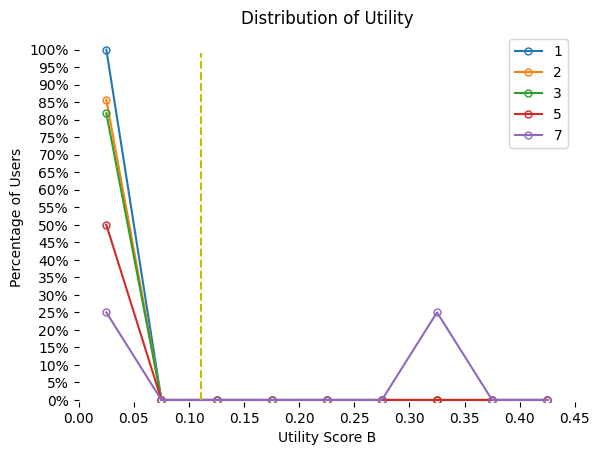

In [65]:
# Define bins with a width of 0.2 and range up to 4
bins = np.arange(0., 0.5, 0.05)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Calculate histogram for each dataset within the range and convert counts to percentages
total_points = {}
hist_per = {}
for k, v in sorted_scale['b'].items():
    total_points[k] = len(v)
    hist, _ = np.histogram(v, bins=bins)
    hist_per[k] = (hist / total_points[k]) * 100



# Plotting the histograms as lines on the same figure
for k in hist_per.keys():
    plt.plot(bin_centers, hist_per[k], linestyle='-', marker='o', mfc='none', label=k, markersize=5)
y = range(100)
x = [0.111] * len(y)
# Plotting the data
#plt.plot(x, y, label='Data Line')
plt.plot(x, y, 'y--') 
plt.xlim([0.0, bins[-1]])  # Adjust x-axis to include the last bin

# Remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Remove grids
plt.grid(False)

# Customize the y-axis to show percentages
max_percentage = 100 #max(max(hist_per[i]) for i in range(len(hist_per)))
plt.ylim([-0.5, max_percentage + (5 - max_percentage % 5)])  # Adjust ylim for visibility
plt.gca().set_yticks(np.arange(0, max_percentage + 1, step=5))
plt.gca().set_yticklabels([f'{x:.0f}%' for x in np.arange(0, max_percentage + 1, step=5)])

plt.xlabel('Utility Score B')
plt.ylabel('Percentage of Users')
plt.title('Distribution of Utility')
plt.legend()
plt.savefig('../result/payoff_b.png')
plt.show()


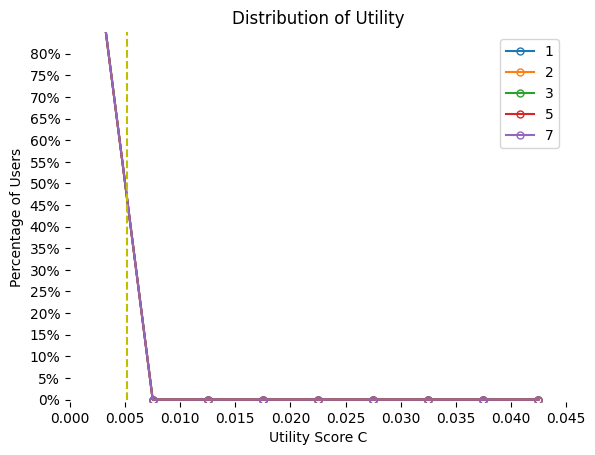

In [66]:
# Define bins with a width of 0.2 and range up to 4
bins = np.arange(0., 0.05, 0.005)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Calculate histogram for each dataset within the range and convert counts to percentages
total_points = {}
hist_per = {}
for k, v in sorted_scale['c'].items():
    total_points[k] = len(v)
    hist, _ = np.histogram(v, bins=bins)
    hist_per[k] = (hist / total_points[k]) * 100



# Plotting the histograms as lines on the same figure
for k in hist_per.keys():
    plt.plot(bin_centers, hist_per[k], linestyle='-', marker='o', mfc='none', label=k, markersize=5)
y = range(100)
x = [0.0052] * len(y)
# Plotting the data
#plt.plot(x, y, label='Data Line')
plt.plot(x, y, 'y--') 
plt.xlim([0.0, bins[-1]])  # Adjust x-axis to include the last bin

# Remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Remove grids
plt.grid(False)

# Customize the y-axis to show percentages
max_percentage = 80 #max(max(hist_per[i]) for i in range(len(hist_per)))
plt.ylim([-0.5, max_percentage + (5 - max_percentage % 5)])  # Adjust ylim for visibility
plt.gca().set_yticks(np.arange(0, max_percentage + 1, step=5))
plt.gca().set_yticklabels([f'{x:.0f}%' for x in np.arange(0, max_percentage + 1, step=5)])

plt.xlabel('Utility Score C')
plt.ylabel('Percentage of Users')
plt.title('Distribution of Utility')
plt.legend()
plt.savefig('../result/payoff_c.png')
plt.show()


In [ ]:
import json
import os
import pandas as pd
from datetime import datetime
import pickle 
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
import torch
import logging
from tqdm import tqdm
import ast
from operator import itemgetter


from utils.tree_utils import *
from utils.utils import *
from dataset import *
from model import *

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import math

In [ ]:
out_dir = '../data/'
data_dir = '../data/'
journalist = 'Lingling_Wei'
batch_size = 4

In [ ]:
def get_set(set_list, n):
    indices = np.arange(n)
    np.random.shuffle(indices)

    # Split sizes
    train_size = int(0.7 * n)
    validation_size = int(0.3 * n)
    test_size = n
    # Split indices
    train_indices = list(indices[:train_size])
    dev_indices = list(indices[train_size:train_size+validation_size])
    test_indices = list(indices[train_size+validation_size:])

    get_items_tr = itemgetter(*train_indices)  # Creates a callable for indexing
    get_items_dev = itemgetter(*dev_indices)
    get_items_te = itemgetter(*test_indices)
    result_tr = list(get_items_tr(set_list))
    result_dev = list(get_items_dev(set_list))
    result_te = list(get_items_te(set_list))

    result_train = result_tr if isinstance(result_tr, list) else [result_tr]
    result_val = result_dev if isinstance(result_dev, list) else [result_dev]
    result_test = result_te if isinstance(result_te, list) else [result_te]

    return result_train, result_val, result_test

def load_data(data_dir, journalist, classes, batch_size, collate):
    ### Data (normalize input inter-event times, then padding to create dataloaders)
    num_classes, num_sequences = 0, 0
    seq_dataset = []
    arr = []
    dp = []
    rel = []
    
    split = [98, 99]
    # JiayangFan: 8: 84
    # muyixiao: 4: 16
    # lingling: 8, 99
    # marianna: 2: 10
    val = 0
    journal_sort = pd.read_csv((os.path.join(data_dir, f'{journalist}/{journalist}_conv_labels.csv')))
    ids = []
    for item in list(journal_sort['conversation_id']):
        if item not in ids:
            ids.append(item)
    id_pair = {}
    id_conv = {}
    for idx in ids:
        id_pair[idx], id_conv[idx] = create_conversation_list(journal_sort[journal_sort['conversation_id']==idx], idx)
    id_data, uid, data, label = create_data(journal_sort, ids)
    prob = pkl.load(open(os.path.join(data_dir, f'{journalist}/{journalist}_edgeprob.pkl'), 'rb'))
    
    with open(os.path.join(data_dir, f'{journalist}/{journalist}_global_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            dp.append(json.loads(line.strip()))

    with open(os.path.join(data_dir, f'{journalist}/{journalist}_local_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            rel.append(json.loads(line.strip()))
    
    global_input = convert_global(dp, id_data)
    local_data = convert_local(rel)
    local_mat = generate_local_mat(local_data, id_data)
    local_input = create_mat(local_mat, mat_type='concat')
    logging.info(f'loaded split {journalist}...')
    # data - dict: dim_process, devtest, args, train, dev, test, index (train/dev/test given as)
    # data[split] - list dicts {'time_since_start': at, 'time_since_last_event': dt, 'type_event': mark} or
    # data[split] - dict {'arrival_times', 'delta_times', 'marks'}
    # data['dim_process'] = Number of accounts = 119,298
    # num_sequences: number of conversations of a journalist
    num_classes = classes
    #num_sequences += len(data[split]['arrival_times'])
    num_sequences = len(set(journal_sort['conversation_id']))
    
    id_train, id_dev, id_test = id_data[:split[0]], id_data[split[0]:split[1]], id_data[split[1]:]
    uid_train, uid_dev, uid_test = uid[:split[0]], uid[split[0]:split[1]], uid[split[1]:]
    X_train, X_dev, X_test = data[:split[0]], data[split[0]:split[1]], data[split[1]:]
    prob_train, prob_dev, prob_test = prob[:split[0]], prob[split[0]:split[1]], prob[split[1]:]
    global_train, global_dev, global_test = global_input[:split[0]], global_input[split[0]:split[1]], global_input[split[1]:]
    local_train, local_dev, local_test = local_input[:split[0]], local_input[split[0]:split[1]], local_input[split[1]:]
    label_train, label_dev, label_test = label[:split[0]], label[split[0]:split[1]], label[split[1]:]

    # id_train, id_dev, id_test = id_data[split[0]:split[1]], id_data[:split[0]], id_data[split[1]:]
    # uid_train, uid_dev, uid_test = uid[split[0]:split[1]], uid[:split[0]], uid[split[1]:]
    # X_train, X_dev, X_test = data[split[0]:split[1]], data[:split[0]], data[split[1]:]
    # prob_train, prob_dev, prob_test = prob[split[0]:split[1]], prob[:split[0]], prob[split[1]:]
    # global_train, global_dev, global_test = global_input[split[0]:split[1]], global_input[:split[0]], global_input[split[1]:]
    # local_train, local_dev, local_test = local_input[split[0]:split[1]], local_input[:split[0]], local_input[split[1]:]
    # label_train, label_dev, label_test = label[split[0]:split[1]], label[:split[0]], label[split[1]:]

    # n = 16
    # id_train, id_dev, id_test = get_set(id_data, n)
    # uid_train, uid_dev, uid_test = get_set(uid, n)
    # X_train, X_dev, X_test = get_set(data, n)
    # prob_train, prob_dev, prob_test = get_set(prob, n)
    # global_train, global_dev, global_test = get_set(global_input, n)
    # local_train, local_dev, local_test = get_set(local_input, n)
    # label_train, label_dev, label_test = get_set(label, n)
    
    d_train = TreeDataset(id_train, uid_train, X_train, prob_train, global_train, local_train, label_train)
    d_val = TreeDataset(id_dev, uid_dev, X_dev, prob_dev, global_dev, local_dev, label_dev)  
    d_test  = TreeDataset(id_test, uid_test, X_test, prob_test, global_test, local_test, label_test)   

    # for padding input sequences to maxlen of batch for running on gpu, and arranging them by length efficient
    collate = collate  
    dl_train = torch.utils.data.DataLoader(d_train, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_val = torch.utils.data.DataLoader(d_val, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_test = torch.utils.data.DataLoader(d_test, batch_size=batch_size, shuffle=False, collate_fn=collate)
    return dl_train, dl_val, dl_test


In [ ]:
# data, labels, prob, global_path, local_path, torch.tensor(masks)
train, val, test = load_data(out_dir, journalist, 3, batch_size, collate)


100%|██████████| 452/452 [00:00<00:00, 42183.82it/s]


In [ ]:
# val
with open(os.path.join(out_dir, f'{journalist}/strat_val.pkl'), 'rb') as file:
    strat_val = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/true_labels.pkl'), 'rb') as file:
    true_labels = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/pred_val.pkl'), 'rb') as file:
    pred_val = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/output_val.pkl'), 'rb') as file:
    output_val = pickle.load(file)

# with open(os.path.join(out_dir, f'{journalist}/predicted.pkl'), 'rb') as file:
#     predicted = pickle.load(file)
# train
with open(os.path.join(out_dir, f'{journalist}/strat_tr.pkl'), 'rb') as file:
    strat_train = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/pred_tr.pkl'), 'rb') as file:
    pred_train = pickle.load(file)
    
with open(os.path.join(out_dir, f'{journalist}/output.pkl'), 'rb') as file:
    output_train = pickle.load(file)
# test
with open(os.path.join(out_dir, f'{journalist}/strat_te.pkl'), 'rb') as file:
    strat_test = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/pred_te.pkl'), 'rb') as file:
    pred_test = pickle.load(file)




In [ ]:
labels_tr = []
strat_tr = []
uid_tr = []
output_tr = []
pred_tr = []
for i, item in enumerate(train):  # Assuming 'val' is your validation dataset
    # Forward pass
    #print(i)
    mask = item.masks.float()
    mask_bool = mask.bool()
    labels = item.labels[mask_bool]

    strat_temp = torch.Tensor(strat_train[i])
    pred_temp = torch.Tensor(pred_train[i])
    output_temp = torch.Tensor(output_train[i])

    # output_temp = torch.Tensor(output_val[i])
    # pred_temp = torch.Tensor(pred_val[i])
    # strat_temp = torch.Tensor(strat_val[i])
    
    output_tr.append(output_temp[mask_bool].tolist())
    pred_tr.append(pred_temp[mask_bool].tolist())
    uid_tr.append(item.uid[mask_bool].tolist()) 
    strat_tr.append(strat_temp[mask_bool].tolist())
    labels_tr.append(labels.tolist())


In [ ]:
pred_te = []
strat_te = []
for i, item in enumerate(test):  # Assuming 'val' is your validation dataset
    # Forward pass
    #print(i)
    mask = item.masks.float()
    mask_bool = mask.bool()
    labels = item.labels[mask_bool]

    strat_temp = torch.Tensor(strat_test[i])
    pred_temp = torch.Tensor(pred_test[i])

    pred_te.append(pred_temp[mask_bool].tolist())
    strat_te.append(strat_temp[mask_bool].tolist())


## User Cluster

In [ ]:
user = np.array([item for sublist in output_tr for item in sublist])
labels = np.array([item for sublist in pred_tr for item in sublist])

In [ ]:
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

# # Standardize the data
# X_standardized = StandardScaler().fit_transform(user)  # X is your multi-dimensional data

# # Run t-SNE
# tsne = TSNE(n_components=2, perplexity=50, learning_rate=200, n_iter=1000)
# X_tsne = tsne.fit_transform(X_standardized)

# # Assuming X_tsne is your t-SNE output and labels is an array of your data point labels
# unique_labels = np.unique(labels)
# colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# plt.figure(figsize=(5, 4))
# # Plot each cluster with a different color
# for i, label in enumerate(unique_labels):
#     plt.scatter(X_tsne[labels == label, 0], X_tsne[labels == label, 1], color=colors[i], label=label, s=10)

# plt.xlabel('t-SNE feature 1')
# plt.ylabel('t-SNE feature 2')
# plt.title('t-SNE Visualization with Cluster Coloring')
# plt.legend()
# plt.show()



In [ ]:
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Example: Replace this with your actual multi-dimensional data
data = user  # Random data with 5 dimensions


pca = PCA(n_components=2)
pca.fit(data)
data_2d = pca.transform(data)

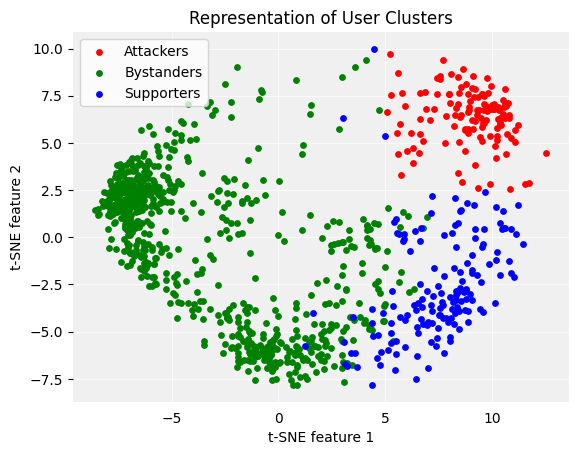

In [ ]:
labe = []
for i, item in enumerate(data_2d):
    if item[1] > 2.5 and item[0] > 5:
        labe.append(0)
    else:
        labe.append(labels[i])
group = labe
cdict = {0: 'Red', 1: 'Green', 2: 'Blue'}
unique_labels = np.unique(labe)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(data_2d[:, 0][ix], data_2d[:, 1][ix], c = cdict[g], label = g, s = 15, zorder=3)
ax.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_facecolor('#f0f0f0')  # Use a light grey background, you can choose any color code
plt.grid(True, which='both', axis='both', color='white', linestyle='-', linewidth=0.5, zorder=0)


plt.tick_params(bottom=False, left=True)
plt.title("Representation of User Clusters")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.legend(['Attackers', 'Bystanders', 'Supporters'])
plt.savefig(f'../result/cluster_{journalist}.png', bbox_inches='tight')
plt.show()

In [ ]:
user_label = {}
for i in range(len(labels_tr)):
    for j in range(len(labels_tr[i])):
        if uid_tr[i][j] not in user_label.keys():
            user_label[uid_tr[i][j]] = ([labels_tr[i][j]], [strat_tr[i][j]])
        else:
            user_label[uid_tr[i][j]][0].append(labels_tr[i][j])
            user_label[uid_tr[i][j]][1].append(strat_tr[i][j])


In [ ]:
np.mean([strat_tr[0][0]], axis=0)

array([0.08586945, 0.10313469, 0.05693509, 0.10864182, 0.17370731,
       0.25151843, 0.06475481, 0.15543842])

In [ ]:
user_strat = {0:[], 1:[], 2:[]}
for k, v in user_label.items():
    if 0 in v[0]:
        user_strat[0].append(np.mean(v[1], axis=0))
    elif 2 in v[0]:
        user_strat[2].append(np.mean(v[1], axis=0))
    else:
        user_strat[1].append(np.mean(v[1], axis=0))

In [ ]:
print(np.mean(user_strat[0], axis=0))
print(np.mean(user_strat[1], axis=0))
print(np.mean(user_strat[2], axis=0))

[0.12677151 0.11697769 0.16980086 0.12518489 0.09913733 0.13606339
 0.10633168 0.11973265]
[0.14566841 0.11490491 0.13483612 0.12687582 0.10511835 0.11471075
 0.14982386 0.10806179]
[0.12547498 0.10136525 0.12200688 0.13564198 0.12121297 0.17086338
 0.11223759 0.11119698]


In [ ]:
strat_0 = []
strat_1 = []
strat_2 = []
for i in range(len(labels_tr)):
    for j, item in enumerate(labels_tr[i]):
        if item == 0:
            strat_0.append(strat_tr[i][j])
        elif item == 1:
            strat_1.append(strat_tr[i][j])
        elif item == 2:
            strat_2.append(strat_tr[i][j])

print(len(strat_0), len(strat_1), len(strat_2))

77 150 141


In [ ]:
#scale = np.array([1e-1, 1, 1e2, 1e2, 1e2, 1e2, 1e2, 1e2])
scale = np.array([0.4, 5e0, 5e0, 1e1, 1e1, 1e1, 1e1, 1e1])
scale1 = np.array([1.5, 2.5, 1.5, 1.5, 2.5, 1.5, 1.5, 1.5])

In [ ]:
ms_0 = (np.mean(np.array(strat_0), 0)) 
ms_1 = (np.mean(np.array(strat_1), 0)) 
ms_2 = (np.mean(np.array(strat_2), 0)) 
print(ms_0, ms_1, ms_2)

[0.12882457 0.10887161 0.19268564 0.11576389 0.10115023 0.12657945
 0.1013096  0.12481501] [0.14318181 0.10525518 0.13969871 0.13371258 0.10855815 0.11665981
 0.13547747 0.11745629] [0.13100814 0.0964545  0.14213638 0.12795892 0.1187837  0.1704576
 0.09498744 0.11821333]


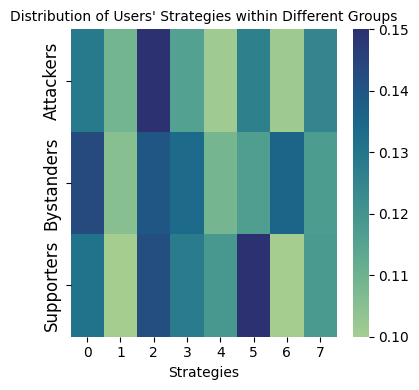

In [ ]:
import seaborn as sns
data_2d = np.vstack([ms_0, ms_1, ms_2])


plt.figure(figsize=(4, 4))  # Adjust the size as needed
sns.heatmap(data_2d, cmap="crest", vmin=0.1, vmax=0.15, yticklabels=["Attackers", "Bystanders", "Supporters"])  # Choose a colormap that fits your data
# viridis, , annot=True
# Optional: Add labels, title, etc.
plt.title("Distribution of Users' Strategies within Different Groups", size=10)
plt.xlabel("Strategies", size=10)#
#plt.ylabel("Row")
plt.tick_params(axis='y', labelsize=12)

# Display the heatmap
plt.tight_layout()

# Display the heatmap
plt.savefig('../result/heatmap_muyixiao.png', bbox_inches='tight')
plt.show()

## draw tree

In [ ]:
max_level = []
max_width = []
for item in global_input[99:]:
    m_level = 0
    m_width = 0
    for x in item:
        level = max(y[0] for y in x)
        width = max(y[2] for y in x)
        if level > m_level:
            m_level = level
        if width > m_width:
            m_width = width
    max_level.append(m_level)
    max_width.append(m_width)
        

In [ ]:
labels = []
for item in pred_test:
    labels.extend(item)

In [ ]:
frac = []
for item in labels:
    l0 = sum(x==0 for x in item) / len(item)
    l1 = sum(x==1 for x in item) / len(item)
    l2 = sum(x==2 for x in item) / len(item)
    frac.append([l0, l1, l2])

# for item in pred_te:
#     l0 = sum(x==0 for x in item) / len(item)
#     l1 = sum(x==1 for x in item) / len(item)
#     l2 = sum(x==2 for x in item) / len(item)
#     frac.append([l0, l1, l2])

In [ ]:
level_tox_sort = {1: 0.071428, 2: 0.0667, 3: 0.045, 6: 0.1818, 7: 0.0325, 24: 0.2780}

In [ ]:
import collections
frac0 = [item[1] for item in frac]
level_tox = {}
for i, k in enumerate(max_level):
    if k not in level_tox.keys():
        level_tox[k] = [frac0[i]]
    else:
        level_tox[k].append(frac0[i])
level_tox_sort = collections.OrderedDict(sorted(level_tox.items()))

scale = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 
         0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
x = list(level_tox_sort.keys()) 
y = [np.mean(list(level_tox_sort.values())[i]) for i in range(len(level_tox))]


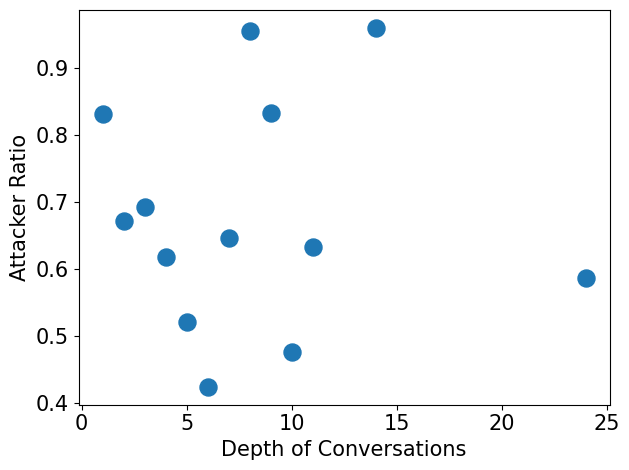

In [ ]:
plt.scatter(x, y, s=150)
#plt.title("Relations Between Depth of Conversations and the Fraction of Attackers", size=20)
plt.xlabel("Depth of Conversations", size=15)#
plt.ylabel("Attacker Ratio", size=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Display the heatmap
plt.tight_layout()

# Display the heatmap
plt.savefig(f'../result/depth_{journalist}.png', bbox_inches='tight')
plt.show()

In [ ]:
def map_id(pair):
    map_pair = {}
    i = 0
    for item in pair:
        if item[0] not in map_pair.keys():
            map_pair[item[0]] = i
            i += 1
        if item[1] not in map_pair.keys():
            map_pair[item[1]] = i
            i += 1
    mapped_pair = [[map_pair[item[0]], map_pair[item[1]]] for item in pair]
    return mapped_pair, map_pair

In [ ]:
labels = [-1, 2, 2, 1, 2, 2, 0, 1, 1, 1, -1, 0, 0, 2, 1, 1, 2, 0, 2, 0, 1, 1]
map_color = {0:'red', 1: 'green', 2: 'blue', -1: 'grey'}
mapped_color = [map_color[item] for item in labels]
pair = id_pair[1019]

node_pairs, map_pair = map_id(id_pair[1019])
node_list = [map_pair[item] for item in id_data[19]]

In [ ]:
missed = []
for item in node_pairs:
    if item[0] not in node_list:
        missed.append(item[0])
    if item[1] not in node_list:
        missed.append(item[1])
print(set(missed))

{0, 10}


In [ ]:
import plotly.graph_objects as go

# Example node pairs
node_pairs = node_pairs

# Function to calculate positions - this will vary greatly depending on your tree structure
positions = {0: (0, 0), 1: (-2.5, -1), 2: (-3, -2), 3: (-2, -2), 4: (-3, -3), 5: (-3.5, -4), 
             6: (-3.5, -5), 7: (-2.5, -4), 8: (-1.5, -1), 9: (-3.5, -3), 10: (-0.5, -1), 
             11: (-1, -2), 12: (0, -2), 13: (-3.5, -6), 14: (0.5, -1), 15: (-4, -3), 
             16: (-2.5, -3), 17: (0.5, -2), 18: (0.5, -3), 19: (0.5, -4), 20: (1.5, -1), 21: (2.5, -1),}


# Create edges
edge_x = []
edge_y = []
for pair in node_pairs:
    x0, y0 = positions[pair[0]]
    x1, y1 = positions[pair[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create nodes
node_x = [pos[0] for pos in positions.values()]
node_y = [pos[1] for pos in positions.values()]

# Create figure
fig = go.Figure()

# Add edges as lines
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=2, color='grey')))

# Add nodes as markers
# mode='markers+text'
fig.add_trace(go.Scatter(x=node_x, y=node_y, mode='markers', text=list(positions.keys()), textposition="bottom center",
                         marker=dict(size=10, color=mapped_color, line=dict(width=2, color='DarkSlateGrey'))))

# Update layout
fig.update_layout(template="plotly_white", xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
fig.show()


In [ ]:
max_dep = 0
max_i = 0
for i, item in enumerate(global_input):
    for x in item:
        if len(x) > max_dep and i <= 99 and len(x) < 10:
            max_dep = len(x)
            max_i = i
print(max_dep, max_i)
print(label[max_i])
print(ids[max_i])

9 38
[2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
774


In [ ]:
labels = [-1, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 
          2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
map_color = {0:'red', 1: 'green', 2: 'blue', -1: 'grey'}
mapped_color = [map_color[item] for item in labels]

node_pairs, map_pair = map_id(id_pair[774])
node_list = [map_pair[item] for item in id_data[38]]

In [ ]:
missed = []
for item in node_pairs:
    if item[0] not in node_list:
        missed.append(item[0])
    if item[1] not in node_list:
        missed.append(item[1])
print(set(missed))

{0}


In [ ]:
import plotly.graph_objects as go

# Example node pairs
node_pairs = node_pairs

# Function to calculate positions - this will vary greatly depending on your tree structure
positions = {0: (0, 0), 1: (0, -1), 2: (0, -2), 3: (0, -3), 4: (0, -4), 5: (-0.5, -5), 
             6: (0.5, -1), 7: (-1, -6), 8: (-1, -7), 9: (0, -6), 10: (-1, -8), 
             11: (-2, -1), 12: (-1.5, -1), 13: (-1, -1), 14: (-0.5, -1), 15: (0.5, -1), 
             16: (1, -1), 17: (1.5, -1), 18: (0.5, -5), 19: (2, -1), 20: (2.5, -1)}


# Create edges
edge_x = []
edge_y = []
for pair in node_pairs:
    x0, y0 = positions[pair[0]]
    x1, y1 = positions[pair[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create nodes
node_x = [pos[0] for pos in positions.values()]
node_y = [pos[1] for pos in positions.values()]

# Create figure
fig = go.Figure()

# Add edges as lines
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=2, color='grey')))

# Add nodes as markers
# mode='markers+text'
fig.add_trace(go.Scatter(x=node_x, y=node_y, mode='markers', text=list(positions.keys()), textposition="bottom center",
                         marker=dict(size=10, color=mapped_color, line=dict(width=2, color='DarkSlateGrey'))))

# Update layout
fig.update_layout(template="plotly_white", xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
fig.show()


In [ ]:
node_pairs, map_pair = map_id(id_pair[579])
node_list = [map_pair[item] for item in id_data[22]]

In [ ]:
missed = []
for item in node_pairs:
    if item[0] not in node_list:
        missed.append(item[0])
    if item[1] not in node_list:
        missed.append(item[1])
print(set(missed))

{0, 64, 51, 86}


In [ ]:
labels = [-1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 
          0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 
          1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 
          0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, -1, 1, 2, 1, 1, 1, 0, 1, 1, 
          2, 1, 0, 2, -1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 
          1, 1, 1, 1, 1, 1, -1, 1, 1, 1]
map_color = {0:'red', 1: 'green', 2: 'blue', -1: 'grey'}
mapped_color = [map_color[item] for item in labels]



In [ ]:
import plotly.graph_objects as go

# Example node pairs
node_pairs = node_pairs

# Function to calculate positions - this will vary greatly depending on your tree structure
positions = {0: (0, 0), 1: (-35, -1), 2: (-34, -1), 3: (-33, -1), 4: (-32, -1), 5: (-31, -1), 6: (-30, -1), 7: (-29, -1), 8: (-28, -1), 9: (-27, -1), 
             10: (-33, -2), 11: (-27, -2), 12: (-26, -1), 13: (-30, -2), 14: (-25, -1), 15: (-24, -1), 16: (-25, -2), 17: (-23, -1), 18: (-22, -1), 19: (-21, -1), 
             20: (-23, -2), 21: (-20, -1), 22: (-19, -1), 23: (-18, -1), 24: (-17, -1), 25: (-16, -1), 26: (-15, -1), 27: (-14, -1), 28: (-13, -1), 29: (-12, -1), 
             30: (-11, -1), 31: (-33, -3), 32: (-10, -1), 33: (-9, -1), 34: (-23, -3), 35: (-8, -1), 36: (-7, -1), 37: (-6, -1), 38: (-5, -1), 39: (-21, -2), 
             40: (-4, -1), 41: (-3, -1), 42: (-2, -1), 43: (-1, -1), 44: (1, -1), 45: (-2, -2), 46: (2, -1), 47: (3, -1), 48: (4, -1), 49: (5, -1), 
             50: (6, -1), 51: (7, -1), 52: (6, -2), 53: (8, -1), 54: (9, -1), 55: (10, -1), 56: (11, -1), 57: (12, -1), 58: (13, -1), 59: (14, -1), 
             60: (15, -1), 61: (16, -1), 62: (14, -2), 63: (14, -3), 64: (17, -1), 65: (17, -2), 66: (19, -1), 67: (20, -1), 68: (21, -1), 69: (20, -2), 
             70: (21, -1), 71: (22, -1), 72: (23, -2), 73: (23, -3), 74: (23, -1), 75: (24, -1), 76: (25, -1), 77: (26, -1), 78: (27, -1), 79: (28, -1), 
             80: (29, -1), 81: (30, -1), 82: (31, -1), 83: (32, -1), 84: (33, -1), 85: (34, -1), 86: (35, -1), 87: (35, -2), 88: (36, -1), 89: (14, -4), }


# Create edges
edge_x = []
edge_y = []
for pair in node_pairs:
    x0, y0 = positions[pair[0]]
    x1, y1 = positions[pair[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create nodes
node_x = [pos[0] for pos in positions.values()]
node_y = [pos[1] for pos in positions.values()]

# Create figure
fig = go.Figure()

# Add edges as lines
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=2, color='grey')))

# Add nodes as markers
# mode='markers+text'
fig.add_trace(go.Scatter(x=node_x, y=node_y, mode='markers', text=list(positions.keys()), textposition="bottom center",
                         marker=dict(size=10, color=mapped_color, line=dict(width=2, color='DarkSlateGrey'))))

# Update layout
fig.update_layout(template="plotly_white", xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
fig.show()


: 

## Strat Evaluation

In [ ]:
def collate(batch):
    batch_li = [list(item) for item in batch]
    data_temp = [row[0] for row in batch_li]
    labels_temp = [torch.Tensor(row[1]) for row in batch_li]
    prob_temp = [torch.Tensor(row[2]) for row in batch_li]
    global_path_temp = [row[3] for row in batch_li]
    local_path_temp = [row[4] for row in batch_li]
    idx_temp = [torch.Tensor(row[5]) for row in batch_li]
    

    padded_data, masks = pad_sequences(data_temp, max_dim=500, pad_token=0)
    padded_labels = pad_labels(labels_temp, max_dim=500, pad_token=0)
    padded_idx = pad_labels(idx_temp, max_dim=500, pad_token=0)
    padded_prob, _ = pad_sequences(prob_temp, max_dim=500, pad_token=0)
    padded_global, _ = pad_sequences(summ(global_path_temp), max_dim=500, pad_token=0)
    padded_local = pad_matrix(local_path_temp, max_dim=500, pad_token=0)

    data= torch.tensor(padded_data).to(torch.int64)
    labels = torch.tensor(padded_labels).to(torch.int64)
    idx = torch.tensor(padded_idx).to(torch.int64)
    prob = torch.tensor(padded_prob).to(torch.float64)
    global_path = torch.tensor(np.array(padded_global)).to(torch.int64)
    #print(type(padded_data), type(padded_data[0]))
    local_path = torch.tensor(np.array(padded_local)).to(torch.int64)
    #labels = torch.nn.utils.rnn.pad_sequence(labels_temp, batch_first=True)
    #prob = torch.nn.utils.rnn.pad_sequence(prob_temp, batch_first=True)
    #global_path = torch.nn.utils.rnn.pad_sequence(global_path_temp, batch_first=True)
    #local_path = torch.nn.utils.rnn.pad_sequence(local_path_temp, batch_first=True)
    #print(masks)
    
    #out_tweet_type = torch.nn.utils.rnn.pad_sequence(out_tweet_types, batch_first=True)
    #print("start")
    return Batch(idx, data, labels, prob, global_path, local_path, torch.tensor(masks))
    
   
def load_data(data_dir, journalist, classes, batch_size, collate):
    ### Data (normalize input inter-event times, then padding to create dataloaders)
    num_classes, num_sequences = 0, 0
    seq_dataset = []
    arr = []
    dp = []
    rel = []
    
    split = [80, 84]
    val = 0
    journal_sort = pd.read_csv((os.path.join(data_dir, f'{journalist}/{journalist}_conv_labels.csv')))
    ids = []
    for item in list(journal_sort['conversation_id']):
        if item not in ids:
            ids.append(item)
    id_pair = {}
    id_conv = {}
    for idx in ids:
        id_pair[idx], id_conv[idx] = create_conversation_list(journal_sort[journal_sort['conversation_id']==idx], idx)
    id_data, data, label = create_data(journal_sort, ids)
    prob = pkl.load(open(os.path.join(data_dir, f'{journalist}/{journalist}_edgeprob.pkl'), 'rb'))
    
    with open(os.path.join(data_dir, f'{journalist}/{journalist}_global_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            dp.append(json.loads(line.strip()))

    with open(os.path.join(data_dir, f'{journalist}/{journalist}_local_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            rel.append(json.loads(line.strip()))
    
    global_input = convert_global(dp, id_data)
    local_data = convert_local(rel)
    local_mat = generate_local_mat(local_data, id_data)
    local_input = create_mat(local_mat, mat_type='concat')
    logging.info(f'loaded split {journalist}...')
    # data - dict: dim_process, devtest, args, train, dev, test, index (train/dev/test given as)
    # data[split] - list dicts {'time_since_start': at, 'time_since_last_event': dt, 'type_event': mark} or
    # data[split] - dict {'arrival_times', 'delta_times', 'marks'}
    # data['dim_process'] = Number of accounts = 119,298
    # num_sequences: number of conversations of a journalist
    num_classes = classes
    #num_sequences += len(data[split]['arrival_times'])
    num_sequences = len(set(journal_sort['conversation_id']))
    
    id_train, id_dev, id_test = id_data[:split[0]], id_data[split[0]:split[1]], id_data[split[1]:]
    X_train, X_dev, X_test = data[:split[0]], data[split[0]:split[1]], data[split[1]:]
    prob_train, prob_dev, prob_test = prob[:split[0]], prob[split[0]:split[1]], prob[split[1]:]
    global_train, global_dev, global_test = global_input[:split[0]], global_input[split[0]:split[1]], global_input[split[1]:]
    local_train, local_dev, local_test = local_input[:split[0]], local_input[split[0]:split[1]], local_input[split[1]:]
    label_train, label_dev, label_test = label[:split[0]], label[split[0]:split[1]], label[split[1]:]

    d_train = TreeDataset(id_train, X_train, prob_train, global_train, local_train, label_train)
    d_val = TreeDataset(id_dev, X_dev, prob_dev, global_dev, local_dev, label_dev)  
    d_test  = TreeDataset(id_test, X_test, prob_test, global_test, local_test, label_test)   

    # for padding input sequences to maxlen of batch for running on gpu, and arranging them by length efficient
    collate = collate  
    dl_train = torch.utils.data.DataLoader(d_train, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_val = torch.utils.data.DataLoader(d_val, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_test = torch.utils.data.DataLoader(d_test, batch_size=batch_size, shuffle=False, collate_fn=collate)
    return dl_train, dl_val, dl_test

train, val, test = load_data(out_dir, journalist, 3, batch_size, collate)

100%|██████████| 2634/2634 [00:00<00:00, 5477.28it/s]


In [ ]:
count = 0
result = []
for i in range(len(llh)):
    a = np.array(llh[i])
    b = np.array(strat_tr[i])
    hit = np.sum(np.sum(a * b, axis=-1) >= 0.7)
    count += 1
    result.append(hit / len(llh[i]))
print(np.sum(result) / count)

0.8088396299383888


In [ ]:
llh = []
for item in train:
    mask = item.masks.float()
    mask_bool = mask.bool()
    sum = item.prob.sum(dim=-1, keepdim=True)
    result = item.prob / sum
    llh.append(result[mask_bool].tolist())
likelihood = []
for i in range(len(llh)):
    a = np.array(llh[i])
    b = np.array(strat_tr[i])
    likelihood.append(np.sum(a * b, axis=-1).tolist())

In [ ]:
def flatten(lst):
    """ Flatten a 2D list into a 1D list """
    return [item for sublist in lst for item in sublist]

In [ ]:
np.sum(binary_predictions)

632

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming `predictions` is your list/array of predicted probabilities and `true_labels` is your ground truth
predictions = likelihood
true_labels = flatten([[1] * len(likelihood[i]) for i in range(len(likelihood))])

# Convert probabilities to binary predictions (e.g., using 0.5 as a threshold)
binary_predictions = flatten([[1 if p > 0.7 else 0 for p in item] for item in predictions])

# Evaluate
accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions, average='weighted', zero_division='warn')
f1 = f1_score(true_labels, binary_predictions)
#roc_auc = roc_auc_score(true_labels, binary_predictions)  # Note: ROC AUC uses the probabilities, not the binary predictions

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Accuracy: 0.7532777115613826, Precision: 1.0, Recall: 0.7532777115613826, F1 Score: 0.8592794017675051


/u/yian3/.conda/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



## Test

In [ ]:
labels_tr = []
strat_tr = []
for i, item in enumerate(val):  # Assuming 'val' is your validation dataset
    # Forward pass
    #print(i)
    mask = item.masks.float()
    mask_bool = mask.bool()
    labels = item.labels[mask_bool]
    strat_temp = torch.Tensor(strat_val[i])
    #pred_temp = torch.Tensor(pred_test[i])
    strat_tr.append(strat_temp[mask_bool].tolist())
    #labels_tr.append(pred_temp[mask_bool].tolist())
    labels_tr.append(labels.tolist())


In [ ]:
strat_0 = []
strat_1 = []
strat_2 = []
for i in range(len(labels_tr)):
    for j, item in enumerate(labels_tr[i]):
        if item == 0:
            strat_0.append(strat_tr[i][j])
        elif item == 1:
            strat_1.append(strat_tr[i][j])
        elif item == 2:
            strat_2.append(strat_tr[i][j])

print(len(strat_0), len(strat_1), len(strat_2))

150 14 7


In [ ]:
ms_0 = np.mean(np.array(strat_0), 0)
ms_1 = np.mean(np.array(strat_1), 0)
ms_2 = np.mean(np.array(strat_2), 0)
print(ms_0, ms_1, ms_2)

[0.11962023 0.14346766 0.11602822 0.12275441 0.13734565 0.10130471
 0.1300965  0.12938263] [0.42894168 0.17817303 0.07215742 0.06545482 0.05932482 0.05118508
 0.07555469 0.06920846] [0.57228889 0.18950889 0.05327873 0.0403331  0.02379078 0.03050997
 0.04997504 0.04031457]


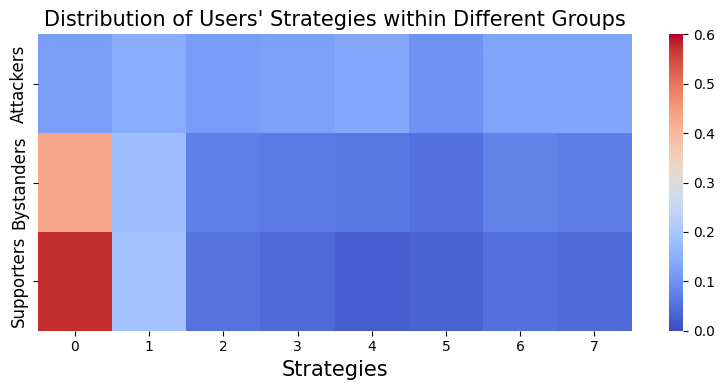

In [ ]:
import seaborn as sns
data_2d = np.vstack([ms_0, ms_1, ms_2])


# Create the heatmap
plt.figure(figsize=(8, 4))  # Adjust the size as needed
sns.heatmap(data_2d, cmap="coolwarm", vmin=0, vmax=0.6, yticklabels=["Attackers", "Bystanders", "Supporters"])  # Choose a colormap that fits your data
# viridis, , annot=True
# Optional: Add labels, title, etc.
plt.title("Distribution of Users' Strategies within Different Groups", size=15)
plt.xlabel("Strategies", size=15)#
#plt.ylabel("Row")
plt.tick_params(axis='y', labelsize=12)

# Display the heatmap
plt.tight_layout()
plt.savefig('../result/heatmap_jiayangfan.png', bbox_inches='tight')
plt.show()

In [ ]:
scale = [1, 1e3, 1e3, 1e3, 1e3, 1e3, 1e3, 1e3]

In [ ]:
np.mean(np.array(strat_0), 0)

array([9.98642266e-01, 1.07979611e-04, 4.87784740e-04, 2.11293217e-04,
       6.35078437e-05, 2.71009480e-04, 1.48113032e-04, 6.80406926e-05])

In [ ]:
np.mean(np.array(strat_1), 0)

array([9.97384846e-01, 2.43167975e-04, 8.06368771e-04, 3.80310346e-04,
       1.42341363e-04, 4.99840535e-04, 3.45563923e-04, 1.97667410e-04])

In [ ]:
np.mean(np.array(strat_2), 0)

array([9.99011886e-01, 8.78300398e-05, 3.19675852e-04, 1.41030914e-04,
       4.80180978e-05, 1.94500281e-04, 1.27388699e-04, 6.96790908e-05])

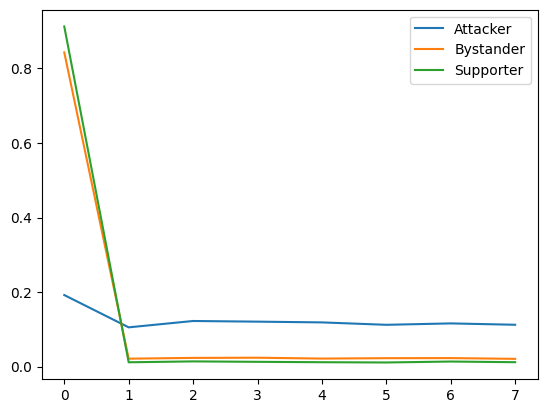

In [ ]:
x = range(8)
plt.plot(x, np.mean(np.array(strat_0), 0), label='Attacker')
plt.plot(x, np.mean(np.array(strat_1), 0), label='Bystander')
plt.plot(x, np.mean(np.array(strat_2), 0), label='Supporter')
plt.legend()
plt.show()

In [ ]:
target_u = []
pred_u = []
strat_u = []

mask_u = []
true_labels = []
for i, item in enumerate(test):
    mask_u.append(item.masks)
    true_labels.append(item.labels)

for i in range(len(mask_u)):
    for j in range(len(mask_u[i])):
        mask_temp = sum(mask_u[i][j])
        pred_u.append(pred_test[i][j][:mask_temp])
        target_u.append(true_labels[i][j][:mask_temp].tolist())
        strat_t = strat_test[i][j][:mask_temp]
        strat_u.append(strat_t)

strat_0 = []
strat_1 = []
strat_2 = []

for i, item in enumerate(target_u):
    for j in range(len(item)):
        if item[j] == 0:
            strat_0.append(strat_u[i][j])
        elif item[j] == 1:
            strat_1.append(strat_u[i][j])
        else:
            strat_2.append(strat_u[i][j])

In [4]:
out_dir = '../data/JiayangFan'
journalist = 'JiayangFan'
with open(os.path.join(out_dir, f'{journalist}_dict.pkl'), 'rb') as f:
    data = pickle.load(f)

with open(os.path.join(out_dir, f'{journalist}_ids.pkl'), 'rb') as f:
    map_id = pickle.load(f)
    
with open(os.path.join(out_dir, f'{journalist}_lan.pkl'), 'rb') as f:
    map_lan = pickle.load(f)

with open(os.path.join(out_dir, f'{journalist}_type.pkl'), 'rb') as f:
    map_type = pickle.load(f)

with open(os.path.join(out_dir, f'{journalist}_reply.pkl'), 'rb') as f:
    map_reply = pickle.load(f)

alice = pd.DataFrame.from_dict(data)
alice_sort = alice.sort_values(by=['created_at'])
conv = pd.read_csv(os.path.join(out_dir, f'{journalist}_conv_labels.csv'))

data = pkl.load(open(os.path.join(out_dir, f'{journalist}_dict.pkl'), 'rb'))
journal = pd.DataFrame.from_dict(data)
journal_sort = pd.read_csv(os.path.join(out_dir, f'{journalist}_conv_labels.csv'))

In [6]:
short_gap = []
for item in journal_sort['time gap']:
    if item < 240:
        short_gap.append(item)
        
max_gap = 240
data = []
# for index, item in journal_sort.iterrows():
#     data.append(superbeta.pdf(1-item['time gap'] / max_gap) + 1e-20)
for item in short_gap:
    data.append(superbeta.pdf(1 - item / max_gap) + 1e-10)

In [7]:
ids = list(set(journal_sort['conversation_id']))
batch_data = []
target_data = []
conv_data = []
ref_data = []
id_data = []
for idx in ids:
    convs = journal_sort[journal_sort['conversation_id'] == idx]
    convs_batch = convs[["type", "possibly_sensitive", "lang", "reply_settings",
                     "retweet_count", "reply_count", "like_count", "quote_count", "impression_count",
                     "mentions", "urls"]]
    conv_data.append(list(convs['conversation_id']))
    ref_data.append(list(convs['reference_id']))
    id_data.append(list(convs['tweet_id']))
    batch_data.append(convs_batch.values.tolist())
    target_data.append(list(convs['labels']))
    
label_data = target_data

In [258]:
contexts = []
for item in conv['context']:
    temp_s = ''
    if item == '0':
        contexts.append('Unified Twitter Taxonomy')

    else:
        for i in ast.literal_eval(item):
            temp_s  += (i['domain']['name'] + ' ' + i['entity']['name'])
        contexts.append(temp_s)
    
annotations = []
for item in conv['annotations']:
    temp_s = ''
    if item == '0':
        annotations.append('Others')

    else:
        for i in ast.literal_eval(item):
            temp_s += i['type'] + ' ' + i['normalized_text']

        annotations.append(temp_s)

In [340]:
journal['context'] = contexts
journal['annotations'] = annotations
journal_sort = journal.sort_values(by=['created_at'])

In [341]:
## topics
## people
ref_ids = []

journal_sort['topics'] = None
journal_sort['ppls'] = None
conv_ids = set(journal_sort['conversation_id'])
for conv in list(conv_ids):
    test_d = journal_sort[journal_sort['conversation_id'] == conv]
    for index, item in test_d.iterrows():
        i = 0
        tweet_id = item['tweet_id']
        ref_id = item['reference_id']
        conv_id = item['conversation_id']
        topic1 = item['context']
        anno1 = item['annotations']
        if len(test_d) == 1:
            topic2 = 'Unified Twitter Taxonomy'
            anno2 = 'Others'
            journal_sort.at[index, 'topics']=[text1, text2]
            journal_sort.at[index, 'ppls']=[anno1, anno2]
            continue
        if ref_id not in ref_ids:
            if tweet_id == test_d.iloc[0]['tweet_id']:
                text2 = test_d[test_d['tweet_id']==test_d.iloc[1]['tweet_id']]['context'].item()
                anno2 = test_d[test_d['tweet_id']==test_d.iloc[1]['tweet_id']]['annotations'].item()
            else:
                text2 = test_d.iloc[i-1]['context']
                anno2 = test_d.iloc[i-1]['annotations']
        else:
            #print(tweet_id,ref_id)
            text2 = test_d[test_d['tweet_id']==ref_id]['context'].item()
            anno2 = test_d[test_d['tweet_id']==ref_id]['annotations'].item()

        ref_ids.append(tweet_id)
        
        journal_sort.at[index, 'topics']=[text1, text2]
        journal_sort.at[index, 'ppls']=[anno1, anno2]
        #print(text2, journal_sort.at[index, 'topics'])
        i += 1
        

In [57]:
journal_sort.to_csv(os.path.join(out_dir, f'{journalist}_context.csv'), index=False)

In [310]:
context_sims = []

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
for index, item in tqdm(journal_sort.iterrows()):
    # Tokenize input text and convert to tensor
    c1 = item['topics'][0]
    c2 = item['topics'][1]
    
    a1 = item['ppls'][0]
    a2 = item['ppls'][1]
    inputs1 = tokenizer(c1, return_tensors="pt")
    inputs2 = tokenizer(c2, return_tensors="pt")

    # Generate embeddings
    with torch.no_grad():
        outputs1 = model(**inputs1)
        outputs2 = model(**inputs2)

    # The last hidden state is the sequence of hidden states of the last layer of the model
    last_hidden_states1 = outputs1.last_hidden_state
    last_hidden_states2 = outputs2.last_hidden_state

    # Optionally, use the [CLS] token's embedding as the representation for the entire sentence
    sentence_embedding1 = last_hidden_states1[:, 0, :]
    sentence_embedding2 = last_hidden_states2[:, 0, :]

    cosine = np.dot(sentence_embedding1,sentence_embedding2.T)/(norm(sentence_embedding1)*norm(sentence_embedding2))
    context_sims.append(cosine)
    #print(sentence_embedding.shape)
    
journal_sort['topics_sim'] = context_sims

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
10632it [17:00, 10.41it/s]


In [346]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
anno_sims = []
for index, item in tqdm(journal_sort.iterrows()):
    # Tokenize input text and convert to tensor
    c1 = item['topics'][0]
    c2 = item['topics'][1]
    
    a1 = item['ppls'][0]
    a2 = item['ppls'][1]
    inputs1 = tokenizer(a1, return_tensors="pt")
    inputs2 = tokenizer(a2, return_tensors="pt")

    # Generate embeddings
    with torch.no_grad():
        outputs1 = model(**inputs1)
        outputs2 = model(**inputs2)

    # The last hidden state is the sequence of hidden states of the last layer of the model
    last_hidden_states1 = outputs1.last_hidden_state
    last_hidden_states2 = outputs2.last_hidden_state

    # Optionally, use the [CLS] token's embedding as the representation for the entire sentence
    sentence_embedding1 = last_hidden_states1[:, 0, :]
    sentence_embedding2 = last_hidden_states2[:, 0, :]

    cosine = np.dot(sentence_embedding1,sentence_embedding2.T)/(norm(sentence_embedding1)*norm(sentence_embedding2))
    anno_sims.append(cosine)
    #print(sentence_embedding.shape)
    
journal_sort['ppls_sim'] = anno_sims
journal_sort = pd.read_csv(os.path.join(out_dir, f'{journalist}_context.csv'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
10632it [13:57, 12.70it/s]


In [24]:
anchor_time = []
test_d = journal_sort[journal_sort['conversation_id']==4]
for index, item in test_d.iterrows():
    anchor_time.append(datetime.strptime(item['created_at'][:19], date_format))

In [25]:
anchor = anchor_time[1] - anchor_time[0]
anchor_hours = divmod(anchor.total_seconds() , 3600)[0]  # 1

In [26]:
## time
from datetime import datetime
ref_ids = []
date_format = "%Y-%m-%dT%H:%M:%S" 
journal_sort['time gap'] = None
conv_ids = set(journal_sort['conversation_id'])
for conv in list(conv_ids):
    test_d = journal_sort[journal_sort['conversation_id'] == conv]
    time0 = datetime.strptime(test_d.iloc[0]['created_at'][:19], date_format)
    k = 0
    for index, item in test_d.iterrows():
        tweet_id = item['tweet_id']
        ref_id = item['reference_id']
        conv_id = item['conversation_id']
        time1 = datetime.strptime(item['created_at'][:19], date_format)
        if len(test_d) == 1:
            journal_sort.at[index, 'time gap']= float(anchor_hours) #/120
            continue
        if ref_id not in ref_ids:
            if tweet_id == test_d.iloc[0]['tweet_id']:
                time2 = datetime.strptime(item['created_at'][:19], date_format) - anchor
            else:
                time2 = datetime.strptime(test_d.iloc[k-1]['created_at'][:19], date_format)
        else:
            #print(test_d[test_d['tweet_id']==ref_id]['created_at'][:19].item())
            time2 = datetime.strptime(test_d[test_d['tweet_id']==ref_id]['created_at'].item()[:19], date_format)
    

        ref_ids.append(tweet_id)
        gap_in_s = (time1 - time2).total_seconds() 
        journal_sort.at[index, 'time gap']= float(divmod(gap_in_s, 3600)[0]) #/ 120
        
        k += 1
        

In [ ]:
## PA * Latest * Field * Self = 2*2*2*2 = 16
## PA: Normal PA (p=0.1, p/#nodes + (1-p)indegree/sum_of_indegree), Uniform (1/#nodes)
## Latest: Normal Latest (beta(10,1), x=1-(outyear-inyear)/(outyear-oldest_year)), Uniform (1/(outyear-oldest_year))
## Field: Similar (1-(1-e^(-||x-y||_2))/(1-e^(-2)), x&y L2-normalized), Different ((1-e^(-||x-y||_2))/(1-e^(-2)), x&y L2-normalized)
## Self: Prefer (coauthors: 0.9/#coauthors, non-coauthors: 0.1/#non-coauthors), Not Prefer (coauthors: 0.1/#coauthors, non-coauthors: 0.9/#non-coauthors)

## 1st: Normal_PA * Normal_Latest * Similar_Field * Prefer_Self
## 2nd: Normal_PA * Normal_Latest * Similar_Field * NotPrefer_Self
## 3rd: Normal_PA * Normal_Latest * Different_Field * Prefer_Self
## 4th: Normal_PA * Normal_Latest * Different_Field * NotPrefer_Self
## 5th: Normal_PA * Uniform_Latest * Similar_Field * Prefer_Self
## 6th: Normal_PA * Uniform_Latest * Similar_Field * NotPrefer_Self
## 7th: Normal_PA * Uniform_Latest * Different_Field * Prefer_Self
## 8th: Normal_PA * Uniform_Latest * Different_Field * NotPrefer_Self
## 9th: Uniform_PA * Normal_Latest * Similar_Field * Prefer_Self
## 10th: Uniform_PA * Normal_Latest * Similar_Field * NotPrefer_Self
## 11th: Uniform_PA * Normal_Latest * Different_Field * Prefer_Self
## 12th: Uniform_PA * Normal_Latest * Different_Field * NotPrefer_Self
## 13th: Uniform_PA * Uniform_Latest * Similar_Field * Prefer_Self
## 14th: Uniform_PA * Uniform_Latest * Similar_Field * NotPrefer_Self
## 15th: Uniform_PA * Uniform_Latest * Different_Field * Prefer_Self
## 16th: Uniform_PA * Uniform_Latest * Different_Field * NotPrefer_Self

In [26]:
superbeta = beta(a=10,b=1)

# def cal_cite_edgeprobs(df):
#     edge_prob = []
#     for index, item in df.iterrows():
         
#         ppl_sim = float(item['ppls_sim'][2:-2])
#         ppl_dif = 1 - ppl_sim

#         topic_sim = float(item['topics_sim'][2:-2])
#         topic_dif = 1 - topic_sim

#         pnormal_latest = superbeta.pdf(1-item['time gap']) + 1e-20
#         puniform_latest = 1 / 168

#         temp1 = np.array([ppl_sim, ppl_dif])
#         temp2 = np.outer([topic_sim,topic_dif],[pnormal_latest,puniform_latest]).flatten()
#         result = np.outer(temp1,temp2).flatten()
#         edge_prob.append(result)
    
#     return np.array(edge_prob, dtype=np.float32)
def cal_cite_edgeprobs(ids):
    edge_prob = [] #np.zeros((len(ids), 8))
    for idx in ids:
        convs = journal_sort[journal_sort['conversation_id'] == idx]
        temp = []
        max_gap = 240 # max(convs['time gap'])
        for index, item in convs.iterrows():

            ppl_sim = float(item['ppls_sim'][2:-2])
            ppl_dif = 1 - ppl_sim

            topic_sim = float(item['topics_sim'][2:-2]) - 1e-3
            topic_dif = 1 - topic_sim

            pnormal_latest = (superbeta.pdf(1-item['time gap'] / max_gap) + 1e-10) / 10
            puniform_latest = 1 / 120

            temp1 = np.array([ppl_sim, ppl_dif])
            temp2 = np.outer([topic_sim,topic_dif],[pnormal_latest,puniform_latest]).flatten()
            result = np.outer(temp1,temp2).flatten()
            temp.append(result)
        edge_prob.append(np.array(temp))
    return edge_prob
edgeprob = cal_cite_edgeprobs(ids)

In [28]:
with open(os.path.join(out_dir, f'{journalist}_edgeprob.pkl'),'wb') as f:
    pickle.dump(edgeprob, f)

In [29]:
with open(os.path.join(out_dir, f'{journalist}_edgeprob.pkl'),'rb') as f:
    edgeprob = pickle.load(f)